In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LinearRegression
import cv2
from skimage.feature import hog
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import hashlib


In [ ]:
# This script loads training and testing datasets from CSV files and prints the first few rows for inspection.

column_names = ["genuine_image", "forged_image", "label"]

train_csv_path = r"C:\\Users\\wahid\\OneDrive\\Desktop\\GenAI\\Assignemtn 1\\Dataset\\train_data.csv"
test_csv_path = "C:\\Users\\wahid\\OneDrive\\Desktop\\GenAI\\Assignemtn 1\\Dataset\\test_data.csv"

train_df = pd.read_csv(train_csv_path, names=column_names)
test_df = pd.read_csv(test_csv_path, names=column_names)

print("Train CSV Data Sample:")
print(train_df.head(), "\n")

print("Test CSV Data Sample:")
print(test_df.head(), "\n")

Train CSV Data Sample:
    genuine_image             forged_image  label
0  068/09_068.png  068_forg/03_0113068.PNG      1
1  068/09_068.png  068_forg/01_0124068.PNG      1
2  068/09_068.png  068_forg/02_0124068.PNG      1
3  068/09_068.png  068_forg/01_0113068.PNG      1
4  068/09_068.png  068_forg/04_0124068.PNG      1 

Test CSV Data Sample:
    genuine_image             forged_image  label
0  068/09_068.png  068_forg/03_0113068.PNG      1
1  068/09_068.png  068_forg/01_0124068.PNG      1
2  068/09_068.png  068_forg/02_0124068.PNG      1
3  068/09_068.png  068_forg/01_0113068.PNG      1
4  068/09_068.png  068_forg/04_0124068.PNG      1 



Basic Information for Train Dataset:
Shape: (23206, 3)

First 5 Rows:
    genuine_image             forged_image  label
0  068/09_068.png  068_forg/03_0113068.PNG      1
1  068/09_068.png  068_forg/01_0124068.PNG      1
2  068/09_068.png  068_forg/02_0124068.PNG      1
3  068/09_068.png  068_forg/01_0113068.PNG      1
4  068/09_068.png  068_forg/04_0124068.PNG      1

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23206 entries, 0 to 23205
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   genuine_image  23206 non-null  object
 1   forged_image   23206 non-null  object
 2   label          23206 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 544.0+ KB
None

Description:
              label
count  23206.000000
mean       0.456951
std        0.498154
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000

Missing Values:
genuine_image    0
forged_image 

C:\Users\wahid\AppData\Local\Temp\ipykernel_9692\1432692133.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'].astype(str), data=df, palette='viridis')


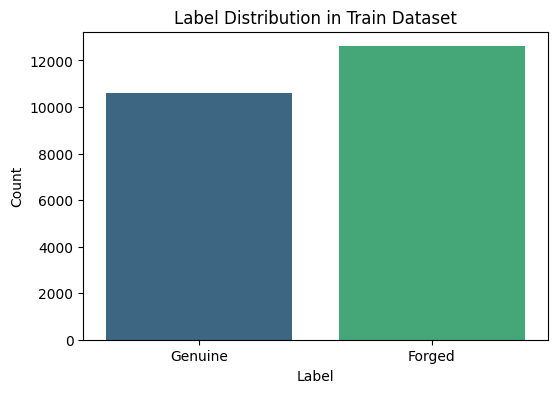

Basic Information for Test Dataset:
Shape: (5748, 3)

First 5 Rows:
    genuine_image             forged_image  label
0  068/09_068.png  068_forg/03_0113068.PNG      1
1  068/09_068.png  068_forg/01_0124068.PNG      1
2  068/09_068.png  068_forg/02_0124068.PNG      1
3  068/09_068.png  068_forg/01_0113068.PNG      1
4  068/09_068.png  068_forg/04_0124068.PNG      1

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5748 entries, 0 to 5747
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   genuine_image  5748 non-null   object
 1   forged_image   5748 non-null   object
 2   label          5748 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 134.8+ KB
None

Description:
             label
count  5748.000000
mean      0.517745
std       0.499728
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000

Missing Values:
genuine_image    0
forged_image     0
label  

C:\Users\wahid\AppData\Local\Temp\ipykernel_9692\1432692133.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'].astype(str), data=df, palette='viridis')


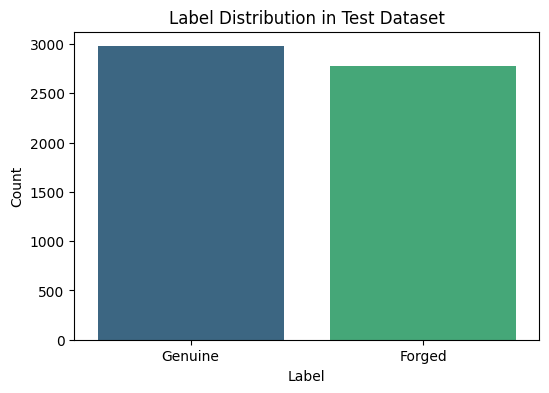

In [3]:
# Function to perform EDA
def eda(df, dataset_name):
    print(f"Basic Information for {dataset_name}:")
    print(f"Shape: {df.shape}")  
    print("\nFirst 5 Rows:")
    print(df.head()) 
    print("\nInfo:")
    print(df.info())  
    print("\nDescription:")
    print(df.describe())  
    print("\nMissing Values:")
    print(df.isnull().sum())  
    print("\n" + "="*50 + "\n")
    df['label'] = df['label'].astype(int)
    

    print(f"Label Distribution for {dataset_name}:")
    label_counts = df['label'].value_counts()
    print(label_counts)
    
    plt.figure(figsize=(6, 4))
    sns.countplot(x=df['label'].astype(str), data=df, palette='viridis')
    plt.title(f'Label Distribution in {dataset_name}')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1], labels=['Genuine', 'Forged'], rotation=0)
    plt.show()

eda(train_df, "Train Dataset")
eda(test_df, "Test Dataset")

In [ ]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

DATASET_PATH = "C:\\Users\\wahid\\OneDrive\\Desktop\\GenAI\\Assignemtn 1\\Dataset"
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
TEST_PATH = os.path.join(DATASET_PATH, "test")
# Loading all the images and scalign ti using opencv 
# This script loads image data for training and testing a model. It reads images from the specified 
# dataset folders, resizes them to 128x128 pixels, and assigns labels (1 for genuine and 0 for forged) 
# based on the folder names. The images are then normalized and reshaped to prepare them for training 
# and testing a machine learning model. It also prints out the count of genuine and forged images.
def load_images_from_folder(base_path):
    X = []
    y = []
    genuine_count = 0
    forged_count = 0

    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):
            label = 1 if "_forg" not in folder else 0  
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                    X.append(img)
                    y.append(label)
                    if label == 1:
                        genuine_count += 1
                    else:
                        forged_count += 1

    print(f"Loaded {len(X)} images from {base_path}")
    print(f"  Genuine signatures: {genuine_count}")
    print(f"  Forged signatures: {forged_count}\n")

    return np.array(X), np.array(y)

print("Loading Training Data...")
X_train, y_train = load_images_from_folder(TRAIN_PATH)

print("Loading Testing Data...")
X_test, y_test = load_images_from_folder(TEST_PATH)

X_train = X_train.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1) / 255.0
X_test = X_test.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1) / 255.0

print(f"Training set: {X_train.shape}, Labels: {y_train.shape}")
print(f"Testing set: {X_test.shape}, Labels: {y_test.shape}\n")



Loading Training Data...
Loaded 1649 images from C:\Users\wahid\OneDrive\Desktop\GenAI\Assignemtn 1\Dataset\train
  Genuine signatures: 887
  Forged signatures: 762

Loading Testing Data...
Loaded 500 images from C:\Users\wahid\OneDrive\Desktop\GenAI\Assignemtn 1\Dataset\test
  Genuine signatures: 252
  Forged signatures: 248

Training set: (1649, 128, 128, 1), Labels: (1649,)
Testing set: (500, 128, 128, 1), Labels: (500,)



In [ ]:
# This script checks for data leakage between the training and testing datasets by flattening the images 
# and comparing the samples in both datasets. It creates sets of the flattened image samples and 
# checks if there are any overlapping samples between the training and testing sets. If any overlap is found, 
# it indicates data leakage. The script prints the number of overlapping samples and alerts if data leakage is detected.
X_train_flat = X_train.reshape(X_train.shape[0], -1)  
X_test_flat = X_test.reshape(X_test.shape[0], -1)

train_set = {tuple(row) for row in X_train_flat}
test_set = {tuple(row) for row in X_test_flat}

overlap = train_set.intersection(test_set)

print(f"Number of overlapping samples: {len(overlap)}")
if len(overlap) == 0:
    print("✅ No data leakage detected!")
else:
    print("⚠️ Data leakage detected! Test set contains training samples.")


Number of overlapping samples: 500
⚠️ Data leakage detected! Test set contains training samples.


In [ ]:
# This script computes unique hash values for each image in the training and testing datasets to detect 
# overlapping images between them. It generates the MD5 hash of each image by converting it to bytes, 
# then checks for any hashes that appear in both the training and testing sets. If overlapping images 
# are found, it prints the number of overlaps and provides examples of the overlapping images.
def compute_image_hash(image):
    return hashlib.md5(image.tobytes()).hexdigest()

train_hashes = {compute_image_hash(img): i for i, img in enumerate(X_train)}
test_hashes = {compute_image_hash(img): i for i, img in enumerate(X_test)}

overlap_hashes = set(train_hashes.keys()).intersection(set(test_hashes.keys()))

print(f"Number of overlapping images: {len(overlap_hashes)}")

if len(overlap_hashes) > 0:
    print("Example overlapping images:")
    for h in list(overlap_hashes)[:5]:  
        print(f"Train Index: {train_hashes[h]}, Test Index: {test_hashes[h]}")

Number of overlapping images: 500
Example overlapping images:
Train Index: 1582, Test Index: 433
Train Index: 1486, Test Index: 337
Train Index: 1423, Test Index: 274
Train Index: 1539, Test Index: 390
Train Index: 1201, Test Index: 52


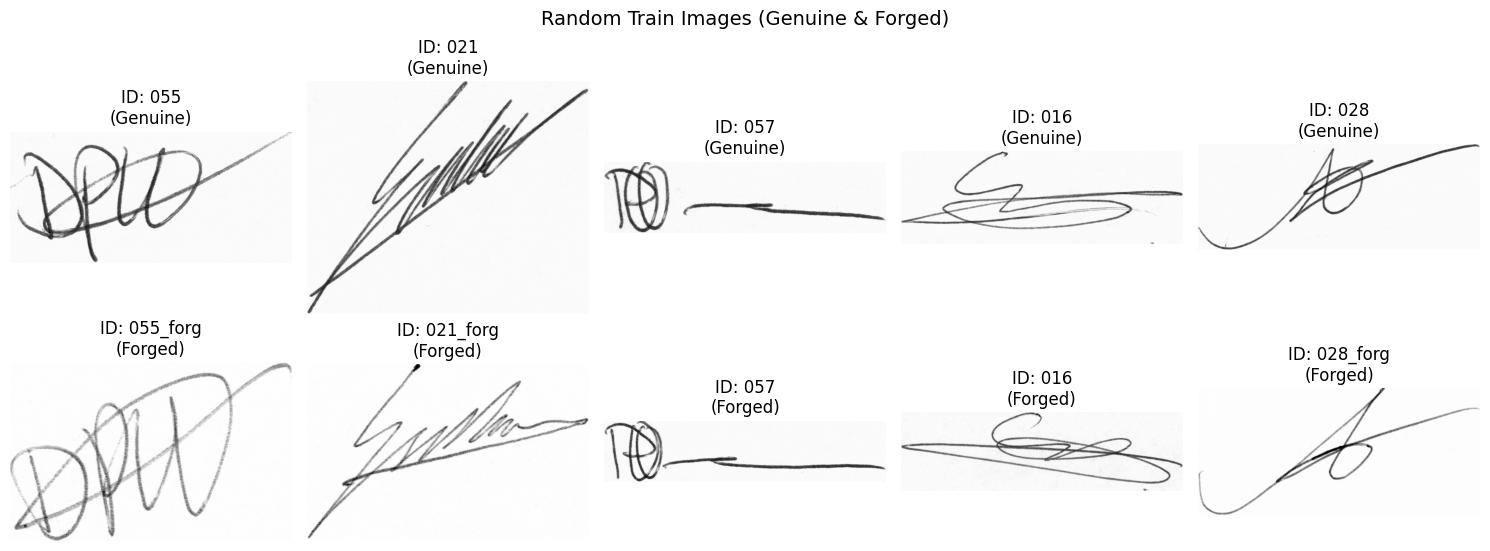

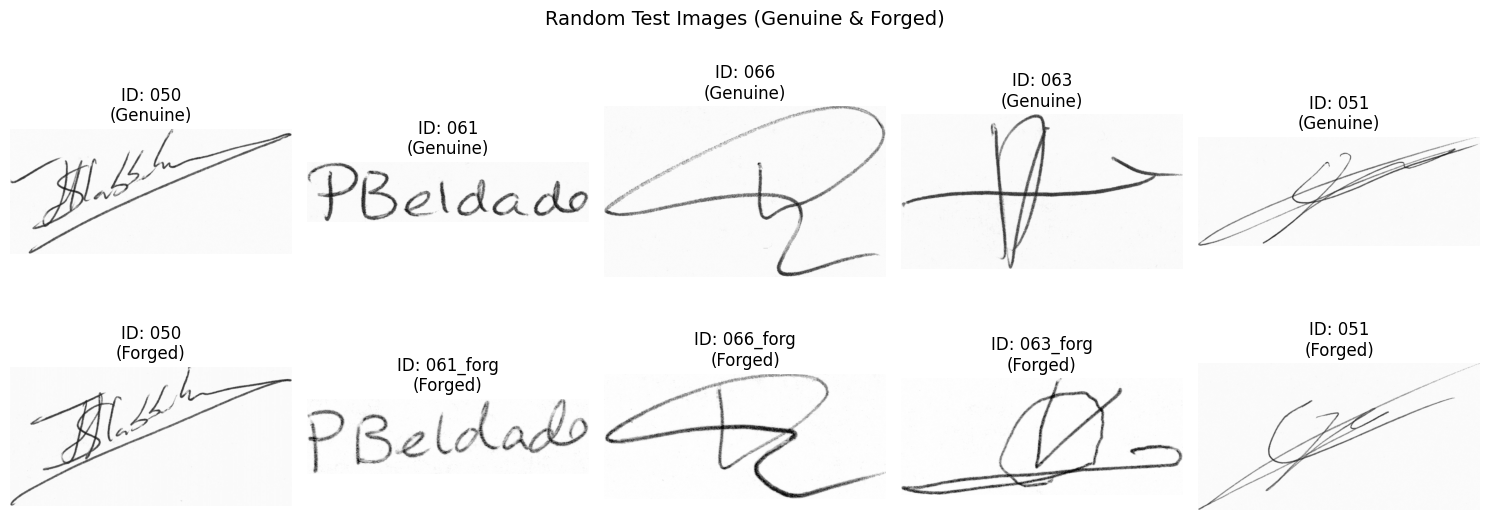

In [ ]:
# This script randomly selects and displays genuine and forged images from the specified training or testing dataset.
# It reads the file paths for both genuine and forged images, and then uses OpenCV to load and display them
# in a 2xN grid (with N being the number of random samples). The script is designed to show a mix of genuine 
# and forged images side-by-side for visual inspection.
def show_random_images(df, dataset_type="train", num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    fig.suptitle(f"Random {dataset_type.capitalize()} Images (Genuine & Forged)", fontsize=14)

    random_samples = df.sample(num_samples, random_state=42)

    for i, idx in enumerate(random_samples.index):
        genuine_path = os.path.join(DATASET_PATH, dataset_type, random_samples.loc[idx, "genuine_image"])
        forged_path = os.path.join(DATASET_PATH, dataset_type, random_samples.loc[idx, "forged_image"])
        
        genuine_img = cv2.imread(genuine_path, cv2.IMREAD_GRAYSCALE)
        forged_img = cv2.imread(forged_path, cv2.IMREAD_GRAYSCALE)

        axes[0, i].imshow(genuine_img, cmap="gray")
        axes[0, i].set_title(f"ID: {random_samples.loc[idx, 'genuine_image'].split('/')[0]}\n(Genuine)")
        axes[0, i].axis("off")

        axes[1, i].imshow(forged_img, cmap="gray")
        axes[1, i].set_title(f"ID: {random_samples.loc[idx, 'forged_image'].split('/')[0]}\n(Forged)")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()

show_random_images(train_df, dataset_type="train")

show_random_images(test_df, dataset_type="test")

In [ ]:
# This script defines, trains, and evaluates a Convolutional Neural Network (CNN) for binary classification
# of genuine and forged signature images. The model is built using Keras with Conv2D layers for feature extraction,
# followed by Dense layers for classification. Data augmentation is applied during training to reduce overfitting. 
# After training, the model is evaluated on the test set, and the accuracy is displayed. The trained model is then 
# saved in the recommended format for future use.
CNNmodel = Sequential([
    Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1)),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.1)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='softmax')  
])

CNNmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)


datagen.fit(X_train)  

print("\nTraining the CNN Model...\n")
history = CNNmodel.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test), epochs=10)

test_loss, test_acc = CNNmodel.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")

CNNmodel.save("signature_cnn_model.keras")
print("\nModel saved successfully as 'signature_cnn_model.keras'")



Training the CNN Model...

Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 33s 568ms/step - accuracy: 0.4966 - loss: 3.8520 - val_accuracy: 0.8000 - val_loss: 1.4803
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 25s 471ms/step - accuracy: 0.5998 - loss: 1.2723 - val_accuracy: 0.5340 - val_loss: 0.9223
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 24s 469ms/step - accuracy: 0.6648 - loss: 0.8271 - val_accuracy: 0.7900 - val_loss: 0.5869
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 24s 468ms/step - accuracy: 0.8076 - loss: 0.6031 - val_accuracy: 0.6520 - val_loss: 0.8472
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 492ms/step - accuracy: 0.8356 - loss: 0.5171 - val_accuracy: 0.7960 - val_loss: 0.5046
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 25s 472ms/step - accuracy: 0.8309 - loss: 0.4881 - val_accuracy: 0.7620 - val_loss: 0.6079
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 24s 467ms/step - accuracy: 0.8531 - loss: 0.4344 - val_accuracy: 0.8060 - val_loss: 0.5566
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 25s 475ms/step - accuracy: 0.86

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step


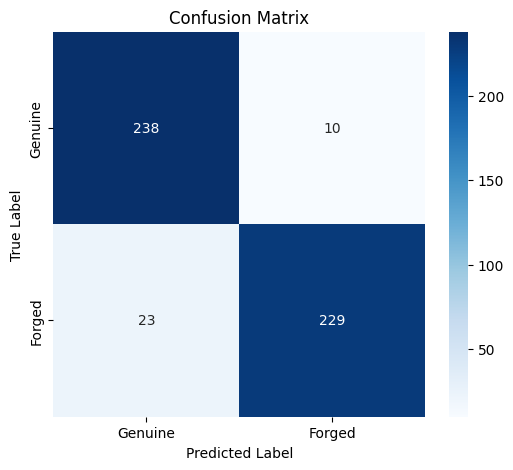


Classification Report:
               precision    recall  f1-score   support

     Genuine       0.91      0.96      0.94       248
      Forged       0.96      0.91      0.93       252

    accuracy                           0.93       500
   macro avg       0.94      0.93      0.93       500
weighted avg       0.94      0.93      0.93       500



In [ ]:
# This script generates predictions for the test set using the trained CNN model,
# then plots a confusion matrix to evaluate the model's performance in classifying 
# genuine vs forged signatures. It also prints a classification report, which includes 
# precision, recall, and F1-score for both classes (Genuine and Forged).
y_pred = (CNNmodel.predict(X_test) > 0.5).astype("int32").flatten()

def plot_confusion_matrix(y_true, y_pred, class_labels=["Genuine", "Forged"]):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(y_test, y_pred)

print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Genuine", "Forged"]))

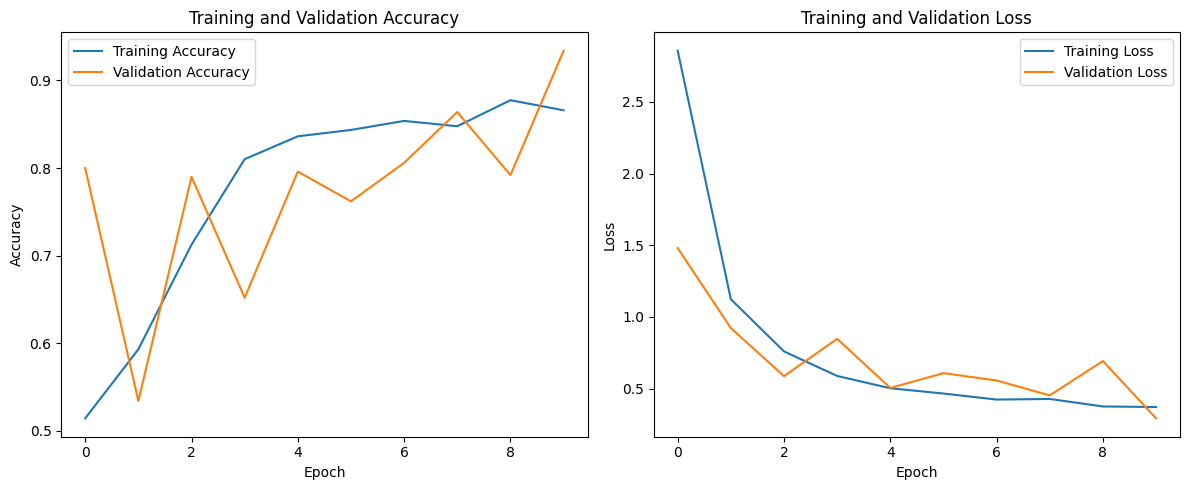

In [ ]:
# This code plots the training and validation accuracy and loss curves 
# to visualize the model's performance over epochs, helping to identify 
# any overfitting or underfitting during the training process.

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# This code applies Histogram of Oriented Gradients (HOG) feature extraction, 
# adds Gaussian noise to the images, applies PCA for dimensionality reduction, 
# and then trains a Logistic Regression model using the extracted features.
# The model is evaluated using a classification report, and the trained model is saved.

def add_noise(img):
    noise = np.random.normal(0, 0.1, img.shape)  
    img = img + noise
    return np.clip(img, 0, 1)

def extract_hog_features(images):
    feature_list = []
    for img in images:
        img = img.reshape(128, 128)  
        img = add_noise(img)

        hog_features = hog(img, pixels_per_cell=(16, 16), 
                           cells_per_block=(2, 2), orientations=8, 
                           feature_vector=True, block_norm="L2-Hys")
        feature_list.append(hog_features)
    return np.array(feature_list)

X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

# Normalize HOG features
scaler = StandardScaler()
X_train_hog = scaler.fit_transform(X_train_hog)
X_test_hog = scaler.transform(X_test_hog)

pca = PCA(n_components=50) 
X_train_hog = pca.fit_transform(X_train_hog)
X_test_hog = pca.transform(X_test_hog)

log_reg_model = LogisticRegression(max_iter=500, C=0.1)  # Lower C to avoid overfitting
log_reg_model.fit(X_train_hog, np.argmax(y_train, axis=1) if y_train.ndim > 1 else y_train)

y_pred_log_reg = log_reg_model.predict(X_test_hog)
print("HOG + Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log_reg)
      
      
)
joblib.dump(log_reg_model, 'hog and logistic regression.joblib')

print("Model saved successfully!")



HOG + Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.70      0.72       248
           1       0.72      0.76      0.74       252

    accuracy                           0.73       500
   macro avg       0.73      0.73      0.73       500
weighted avg       0.73      0.73      0.73       500

Model saved successfully!


In [ ]:
# This code extracts SIFT features from images, preprocesses them (padding, scaling), trains a linear SVM classifier on the features, evaluates the model on the test set, and saves the trained model using joblib for future use.







sift = cv2.SIFT_create()

def extract_sift_features(images):
    sift_features = []
    for img in images:
        img_uint8 = (img * 255).astype(np.uint8)  
        keypoints, descriptors = sift.detectAndCompute(img_uint8, None)

        if descriptors is not None:
            sift_features.append(descriptors.flatten())
        else:
            sift_features.append(np.zeros(128))  

    return np.array(sift_features, dtype=object)  

X_train_sift = extract_sift_features(X_train)  
X_test_sift = extract_sift_features(X_test)    

max_features = 128  
X_train_sift = np.array([np.pad(f, (0, max_features - len(f)), mode='constant') if len(f) < max_features else f[:max_features] for f in X_train_sift])
X_test_sift = np.array([np.pad(f, (0, max_features - len(f)), mode='constant') if len(f) < max_features else f[:max_features] for f in X_test_sift])

scaler = StandardScaler()
X_train_sift = scaler.fit_transform(X_train_sift)
X_test_sift = scaler.transform(X_test_sift)

if y_train.ndim > 1:
    y_train = np.argmax(y_train, axis=1) 

svm_model_sift = SVC(kernel='linear')
svm_model_sift.fit(X_train_sift, y_train)

y_pred_sift = svm_model_sift.predict(X_test_sift)
print("SIFT + SVM Classification Report:\n", classification_report(y_test, y_pred_sift))

joblib.dump(svm_model_sift, 'sift_pca_svm_model.joblib')

print("Model saved successfully!")

SIFT + SVM Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.54      0.59       248
           1       0.61      0.72      0.66       252

    accuracy                           0.63       500
   macro avg       0.63      0.63      0.63       500
weighted avg       0.63      0.63      0.63       500

Model saved successfully!


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9229 - loss: 0.3029
CNN Test Accuracy: 0.9340
SIFT + SVM Test Accuracy: 0.6300
HOG + Logistic Regression Test Accuracy: 0.7300


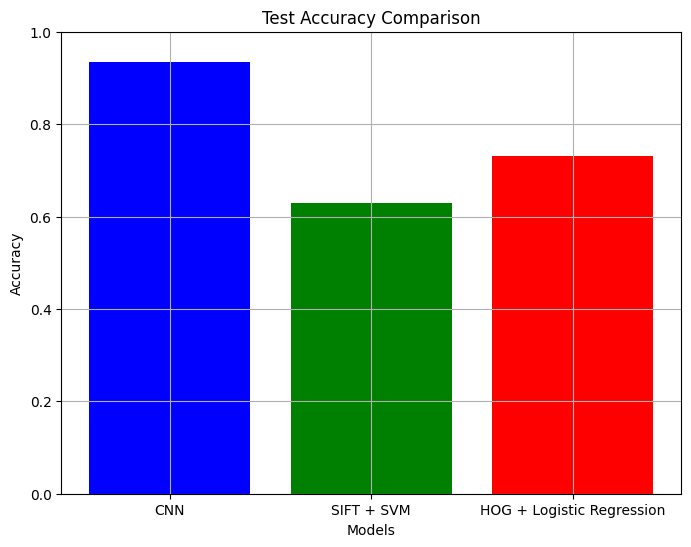

In [ ]:
# This code evaluates the performance of three models (CNN, SIFT + SVM, and HOG + Logistic Regression) on the test set, prints their test accuracies, and plots a bar chart to compare the test accuracies of the models.

test_loss_cnn, test_acc_cnn = CNNmodel.evaluate(X_test, y_test)

test_acc_sift = svm_model_sift.score(X_test_sift, y_test)

test_acc_hog = log_reg_model.score(X_test_hog, y_test)

print(f"CNN Test Accuracy: {test_acc_cnn:.4f}")
print(f"SIFT + SVM Test Accuracy: {test_acc_sift:.4f}")
print(f"HOG + Logistic Regression Test Accuracy: {test_acc_hog:.4f}")

plt.figure(figsize=(8, 6))
plt.bar(['CNN', 'SIFT + SVM', 'HOG + Logistic Regression'], [test_acc_cnn, test_acc_sift, test_acc_hog], color=['blue', 'green', 'red'])
plt.title('Test Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  
plt.grid(True)
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step


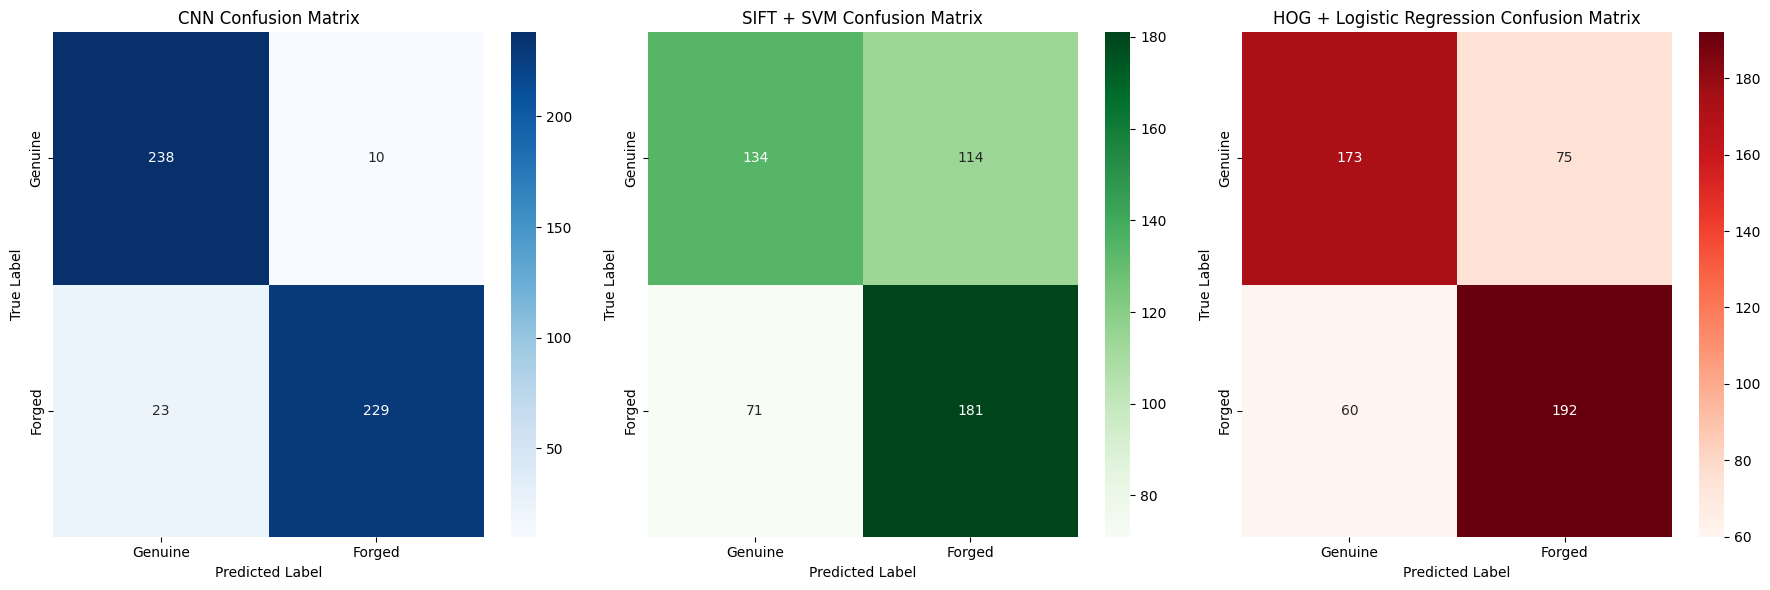

In [ ]:
# This code generates predictions for the three models (CNN, SIFT + SVM, and HOG + Logistic Regression) on the test set, computes the confusion matrices for each model, and then visualizes the confusion matrices using heatmaps to compare the performance of the models.


y_pred_cnn = (CNNmodel.predict(X_test) > 0.5).astype("int32").flatten()  
y_pred_sift = svm_model_sift.predict(X_test_sift) 
y_pred_hog = log_reg_model.predict(X_test_hog)  

cm_cnn = confusion_matrix(y_test, y_pred_cnn)
cm_sift = confusion_matrix(y_test, y_pred_sift)
cm_hog = confusion_matrix(y_test, y_pred_hog)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Blues", xticklabels=["Genuine", "Forged"], yticklabels=["Genuine", "Forged"], ax=axes[0])
axes[0].set_title('CNN Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

sns.heatmap(cm_sift, annot=True, fmt="d", cmap="Greens", xticklabels=["Genuine", "Forged"], yticklabels=["Genuine", "Forged"], ax=axes[1])
axes[1].set_title('SIFT + SVM Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

sns.heatmap(cm_hog, annot=True, fmt="d", cmap="Reds", xticklabels=["Genuine", "Forged"], yticklabels=["Genuine", "Forged"], ax=axes[2])
axes[2].set_title('HOG + Logistic Regression Confusion Matrix')
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')

plt.tight_layout()
plt.show()

In [1]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model("signature_cnn_model.keras")

# Print the model summary
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,175,621 (84.59 MB)

 Trainable params: 7,391,873 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,783,748 (56.40 MB)